Import necessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from pathlib import Path
import warnings
import zipfile
warnings.filterwarnings('ignore')

Load Dataset

In [ ]:
training = './Training'
testing = './Testing'

In [ ]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(training,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(testing,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
class_names = train_ds.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
def show_images(dataset, title):
  plt.figure(figsize = (6,6))
  for images, labels in dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3,3,i+1)
      plt.imshow(images[i].numpy().astype('uint8'))
      plt.title(class_names[labels[i]])
      plt.axis("off")
  plt.suptitle(title)
  plt.show()

Visualize some images from each class.

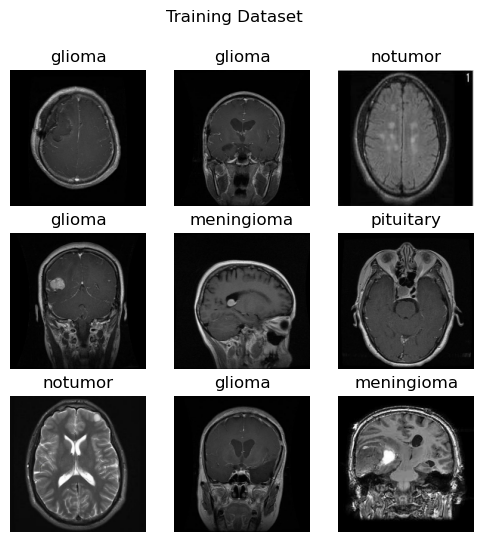

In [ ]:
show_images(train_ds, "Training Dataset")

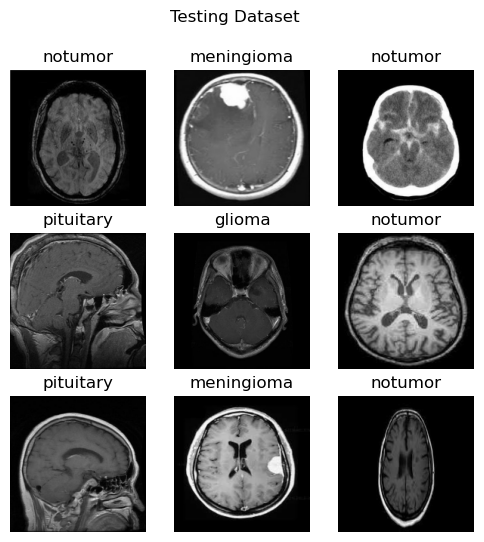

In [ ]:
show_images(test_ds, 'Testing Dataset')

**DATA PREPROCESSING**

We use the Keras ImageDataGenerator for data augmentation and normalization.

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(training,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 5712 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory(testing,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

Found 1311 images belonging to 4 classes.


**BUILD THE MODEL**

We define a custom Convolutional Neural Network (CNN) architecture using Keras.

In [ ]:
model = models.Sequential([
    layers.InputLayer(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,492 (25.36 MB)

 Trainable params: 6,647,492 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

We compile the CNN model using Adam optimizer and train it on the training dataset.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=3,
                               restore_best_weights=True)

In [ ]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10,
                   callbacks=[early_stopping]
                   )

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 124s 670ms/step - accuracy: 0.5160 - loss: 1.2087 - val_accuracy: 0.7597 - val_loss: 0.6055
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 110s 611ms/step - accuracy: 0.7711 - loss: 0.5683 - val_accuracy: 0.7498 - val_loss: 0.6212
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 123s 686ms/step - accuracy: 0.8281 - loss: 0.4423 - val_accuracy: 0.8223 - val_loss: 0.4649
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 892ms/step - accuracy: 0.8506 - loss: 0.3908 - val_accuracy: 0.8291 - val_loss: 0.4344
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 119s 662ms/step - accuracy: 0.8801 - loss: 0.3159 - val_accuracy: 0.8627 - val_loss: 0.3541
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 117s 652ms/step - accuracy: 0.8920 - loss: 0.2780 - val_accuracy: 0.8749 - val_loss: 0.3294
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 118s 656ms/step - accuracy: 0.9146 - loss: 0.2284 - val_accuracy: 0.8818 - val_loss: 0.3196
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 624ms/step - accuracy: 0.9219 -

**MODEL EVALUATION**

In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f'Test Accuracy: {accuracy:.2f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.9318 - loss: 0.1868
Test Accuracy: 0.94


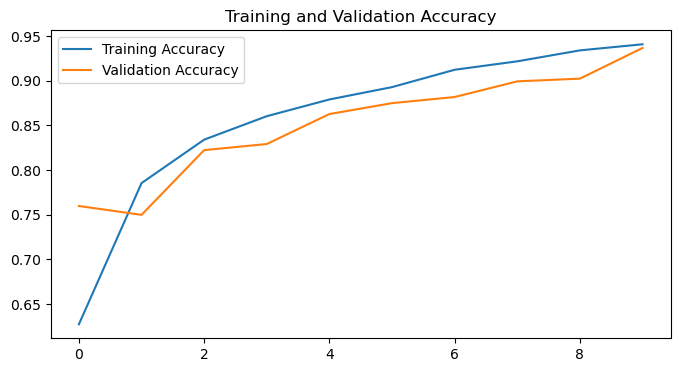

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

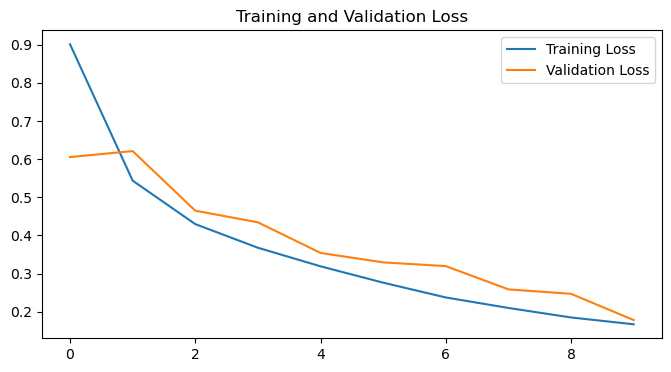

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Save the trained CNN model for future use.

In [ ]:
model.save('brain_tumor_model.keras')

In [ ]:
# Load the saved model
loaded_model = load_model('brain_tumor_model.keras')

Finally, we show how to load the saved model and make predictions on custom MRI images.

In [ ]:
# Load and preprocess the custom image
img_path = './Testing/pituitary/Te-pi_0023.jpg'
img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

# Convert the image to array
img_array = image.img_to_array(img)

# Expand dimensions to match the model's expected input shape (batch size, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

# Rescale pixel values (same as in training)
img_array = img_array / 255.0

# Make predictions
predictions = loaded_model.predict(img_array)

# Decode the prediction (index to class label)
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Class labels in the same order as used during training
class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Output the predicted class
predicted_class = class_labels[predicted_class_index]
print(f'Predicted class: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Predicted class: pituitary
